# Big Mart Sales Prediction Using Python

## Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

## Exploratory Data Analysis (EDA)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Dimensions of Data

In [3]:
train.shape

(8523, 12)

In [4]:
test.shape

(5681, 11)

### Features of Data

In [5]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [6]:
test.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

### Structure of Data

In [7]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [8]:
test.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
dtype: object

### Target Variable

Since our target variable is continuous, we can visualise it by plotting its histogram.

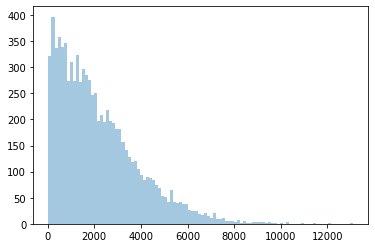

In [9]:
outlet_sales_array = np.array(train['Item_Outlet_Sales'])
sns.distplot(outlet_sales_array, bins=100, kde=False)

### Missing Value Treatment

Missing data can have a severe impact on building predictive models because the missing values might be contain some vital information which could help in making better predictions. So, it becomes imperative to carry out missing data imputation. There are different methods to treat missing values based on the problem and the data. Some of the common techniques are as follows:

Deletion of rows: In train dataset, observations having missing values in any variable are deleted. The downside of this method is the loss of information and drop in prediction power of model.

Mean/Median/Mode Imputation: In case of continuous variable, missing values can be replaced with mean or median of all known values of that variable. For categorical variables, we can use mode of the given values to replace the missing values.

Building Prediction Model: We can even make a predictive model to impute missing data in a variable. Here we will treat the variable having missing data as the target variable and the other variables as predictors. We will divide our data into 2 datasets—one without any missing value for that variable and the other with missing values for that variable. The former set would be used as training set to build the predictive model and it would then be applied to the latter set to predict the missing values.

You can try the following code to quickly find missing values in a variable.

In [10]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [11]:
train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace=True)

Now let’s see if there is still any missing data in Item_Weight

In [12]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

0 missing values! It means we have successfully imputed the missing data in the feature.

Replacing 0’s in Item_Visibility variable
Similarly, zeroes in Item_Visibility variable can be replaced with Item_Identifier wise mean values of Item_Visibility. It can be visualized in the plot below.

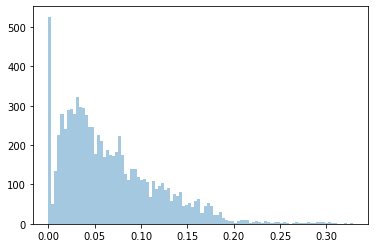

In [13]:
item_visibility_array = np.array(train['Item_Visibility'])
sns.distplot(item_visibility_array, bins=100, kde=False)

Let’s replace the zeroes.

In [14]:
train['Item_Visibility'].fillna(train['Item_Visibility'].mean(), inplace=True)

In [15]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Correlated Variables

Let’s examine the correlated features of train dataset. 
Correlation varies from -1 to 1.

1. negative correlation: < 0 and >= -1
2. positive correlation: > 0 and <= 1
3. no correlation: 0

It is not desirable to have correlated features if we are using linear regressions.

In [16]:
corr = train.corr(method ='pearson')
corr

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.012049,0.024756,-0.008301,0.011550
Item_Visibility,-0.012049,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.024756,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.008301,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.011550,-0.128625,0.567574,-0.049135,1.000000


### XGBoost

XGBoost is a fast and efficient algorithm and has been used to by the winners of many data science competitions. It’s a boosting algorithm and you may refer this article to know more about boosting. XGBoost works only with numeric variables and we have already replaced the categorical variables with numeric variables. There are many tuning parameters in XGBoost which can be broadly classified into General Parameters, Booster Parameters and Task Parameters.

General parameters refer to which booster we are using to do boosting. The commonly used are tree or linear model Booster parameters depend on which booster you have chosen Learning Task parameters that decide on the learning scenario, for example, regression tasks may use different parameters with ranking tasks. Let’s have a look at the parameters that we are going to use in our model.

1. eta: It is also known as the learning rate or the shrinkage factor. It actually shrinks the feature 2. 2. weights to make the boosting process more conservative. The range is 0 to 1. Low eta value means the model is more robust to overfitting.
3. gamma: The range is 0 to ∞. Larger the gamma more conservative the algorithm is.
4. max_depth: We can specify maximum depth of a tree using this parameter.
5. subsample: It is the proportion of rows that the model will randomly select to grow trees.
6. colsample_bytree: It is the ratio of variables randomly chosen to build each tree in the model.

In [17]:
train_copy = train.copy()

In [18]:
le = LabelEncoder() 

train_copy['Item_Identifier']= le.fit_transform(train_copy['Item_Identifier'])
train_copy['Item_Fat_Content']= le.fit_transform(train_copy['Item_Fat_Content'])
train_copy['Item_Type']= le.fit_transform(train_copy['Item_Type'])
train_copy['Outlet_Identifier']= le.fit_transform(train_copy['Outlet_Identifier'])
train_copy['Outlet_Location_Type']= le.fit_transform(train_copy['Outlet_Location_Type'])
train_copy['Outlet_Type']= le.fit_transform(train_copy['Outlet_Type'])

In [19]:
train_copy['Outlet_Size']

0       Medium
1       Medium
2       Medium
3          NaN
4         High
         ...  
8518      High
8519       NaN
8520     Small
8521    Medium
8522     Small
Name: Outlet_Size, Length: 8523, dtype: object

In [20]:
train_copy['Outlet_Size'].fillna('Small', inplace=True)

In [21]:
train_copy['Outlet_Size'].isna().sum()

0

In [22]:
train_copy['Outlet_Size']= le.fit_transform(train_copy['Outlet_Size'])

In [23]:
X, y = train_copy.iloc[:,:-1],train_copy.iloc[:,-1]

In [24]:
train_copy_dmatrix = xgb.DMatrix(data=X,label=y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [26]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [27]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
print (len(preds))

[15:09:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
1705


In [28]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=train_copy_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[15:09:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2574.858154,20.176955,2575.335205,43.786356
1,2407.716797,20.479752,2408.928385,43.141903
2,2259.592448,22.154690,2260.943522,46.924416
3,2117.589112,6.256007,2121.178223,55.419448
4,2015.665893,9.957155,2021.175049,60.680381


In [30]:
xg_reg = xgb.train(params=params, dtrain=train_copy_dmatrix, num_boost_round=10)

[15:09:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


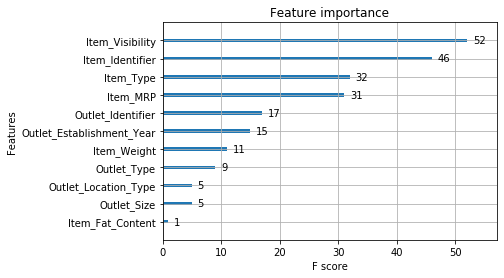

In [31]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [32]:
test_copy = test.copy()

In [33]:
test_copy.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [34]:
test_copy['Item_Weight'].fillna(test_copy['Item_Weight'].mean(), inplace=True)

In [35]:
test_copy.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [36]:
test_copy['Outlet_Size'].fillna('Small', inplace=True)

In [37]:
test_copy.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [38]:
test_copy.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
dtype: object

In [39]:
le = LabelEncoder() 

test_copy['Item_Identifier']= le.fit_transform(test_copy['Item_Identifier'])
test_copy['Item_Fat_Content']= le.fit_transform(test_copy['Item_Fat_Content'])
test_copy['Item_Type']= le.fit_transform(test_copy['Item_Type'])
test_copy['Outlet_Identifier']= le.fit_transform(test_copy['Outlet_Identifier'])
test_copy['Outlet_Location_Type']= le.fit_transform(test_copy['Outlet_Location_Type'])
test_copy['Outlet_Type']= le.fit_transform(test_copy['Outlet_Type'])
test_copy['Outlet_Size']= le.fit_transform(test_copy['Outlet_Size'])

In [40]:
test_copy.dtypes

Item_Identifier                int32
Item_Weight                  float64
Item_Fat_Content               int32
Item_Visibility              float64
Item_Type                      int32
Item_MRP                     float64
Outlet_Identifier              int32
Outlet_Establishment_Year      int64
Outlet_Size                    int32
Outlet_Location_Type           int32
Outlet_Type                    int32
dtype: object

In [41]:
feat_col = test_copy.columns

In [42]:
# predicting on actual test data
XGB = XGBRegressor()
XGB.fit(X_train, y_train)
X_t = test_copy[feat_col]
y_result = XGB.predict(X_t)

In [43]:
y_result
print (len(y_result))

5681


In [44]:
y_result = abs(y_result)

In [45]:
subm = pd.DataFrame()

In [46]:
subm['Item_Identifier'] = test['Item_Identifier']
subm

,Item_Identifier
0,FDW58
1,FDW14
2,NCN55
3,FDQ58
4,FDY38
...,...
5676,FDB58
5677,FDD47
5678,NCO17
5679,FDJ26


In [47]:
subm['Outlet_Identifier'] = test['Outlet_Identifier']
subm

,Item_Identifier,Outlet_Identifier
0,FDW58,OUT049
1,FDW14,OUT017
2,NCN55,OUT010
3,FDQ58,OUT017
4,FDY38,OUT027
...,...,...
5676,FDB58,OUT046
5677,FDD47,OUT018
5678,NCO17,OUT045
5679,FDJ26,OUT017


In [48]:
subm["Item_Outlet_Sales"] = y_result
subm

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1322.875122
1,FDW14,OUT017,1366.292725
2,NCN55,OUT010,530.278625
3,FDQ58,OUT017,2812.999268
4,FDY38,OUT027,6192.037109
...,...,...,...
5676,FDB58,OUT046,1879.342041
5677,FDD47,OUT018,2537.541016
5678,NCO17,OUT045,1792.498047
5679,FDJ26,OUT017,3346.793701


In [49]:
subm = subm.sort_index()
subm.to_csv('XGB_subm.csv',index = False)